## Numerical Experiments: Nonlinear Regression Model

We consider the Hessian of the loss-function of the nonlinear regression model
$$\mathcal{H}=\frac{1}{n}\sum_{\ell=1}^n\tau_\ell\cdot x_\ell x_\ell^\top$$
with
$$\tau_\ell:=\phi'(w^\top x_\ell)^2+\phi''(w^\top x_\ell)(\phi(w^\top x_\ell)-y_\ell)$$
where $X,w$ and $y$ are random with i.i.d. entries, and $\phi$ the nonlinearity. We also empose that $w^\top x_\ell=\mathcal{O}(1)$ for all $\ell=1,\dots,n$, which can be achieved by additionally requiring that $w$ has variance $1/d$. We wish to numerically test our first main result.

\
\
**Theorem (Main Result I)** *Denote $Q_d(z)$ to be the resolvent of $\mathcal{H}$ and assume that there exists a Stieltjes transform $m$ (of some probability measure $\mu$) such that $m_d(z):=\frac{1}{d}\operatorname{Tr}Q_d(z)\stackrel{a.s.}{\to}m(z)$ for all $z\in\mathbb{C}_+$, $n/d\to\alpha\in(0,\infty)$ and that there exists a function $F:\mathbb{C}_+\to\mathbb{C}_+$ such that, point-wise,*
$$F_n(z):=\frac{1}{n}\sum_{\ell=1}^n \frac{\tau_\ell}{1+\frac{\tau_\ell}{\alpha}z}\stackrel{a.s.}{\to}F(z)$$
*as $n,d\to\infty$. Then the Stieltjes transform $m(z)$ satisfies the fixed point equation*
$$m(z)=\frac{1}{F(m(z))-z}$$
*for all $z\in\mathbb{C}_+$.*

In [8]:
# INITIALIZATION

import numpy as np
from matplotlib import pyplot as plt

# returns the l-th diagonal element of the diagonal matrix D in H = 1/n XDX^\top
def computeTau(alpha, phi, phi1, phi2, X, w, y, l):
    return phi1(np.dot(w.T, X[:,l-1]))**2 + phi2(np.dot(w.T, X[:,l-1])) * (phi(np.dot(w.T, X[:,l-1])) - y[l-1])

# generate empirical data
def plotEmpirical(alpha, phi, phi1, phi2, d, bins):
    
    n = int(alpha * d)
    X = np.random.normal(size=(d,n))
    y = np.random.normal(size=(n,1))
    w = np.random.normal(0, 1/d, size=(d,1))

    # compute Hessian
    vec = []
    for l in range(n):
        tau = computeTau(alpha, phi, phi1, phi2, X, w, y, l)
        vec = np.append(vec, tau)

    D = np.diag(vec)
    H = 1/n * X @ D @ X.T

    eigs = np.linalg.eigvalsh(H)
    plt.hist(eigs, bins=bins, density=True)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\mu(d\lambda)$')
    return eigs.min(), eigs.max()


# represents the approximation F_n(z) of F(z)
def approximateF(alpha, phi, phi1, phi2, X, w, y, K, z):

    n = int(alpha * K)
    sum = 0

    for l in range(1, K+1):
        tau = computeTau(alpha, phi, phi1, phi2, X, w, y, l)
        sum += tau / (1 + (tau / alpha) * z)

    return (1/K) * sum

# reconstruct limiting spectral density
def plotDensity(alpha, F, title, xmin, xmax):

    lambdas = np.linspace(xmin, xmax , num=1000)
    epsilons = np.logspace(4, -3, num=1000)
    m_values = 1

    for eps in epsilons:
        m_values = 1 / (F(m_values) - (lambdas + eps*1j)) # fixed point equation

    mu = np.imag(m_values) / np.pi # Stieltjes inversion

    plt.plot(lambdas, mu, color="red")
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\mu(d\lambda)$')
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(top=mu.max() * 1.1)


# generate empirical data (Monte-Carlo Simulation)
def plotEmpiricalMC(N, alpha, phi, phi1, phi2, d):
    ee, ev = np.linalg.eigh(sampleHessians(N, alpha, phi, phi1, phi2, d))
    nn, bb, _ = plt.hist(ee.ravel(), bins="auto", density=True)

    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\mu(d\lambda)$')
    plt.ylim(top=nn[1:].max() * 1.1)

# single random Hessian generator (phi and its derivatives are lambda functions)
def singleHessian(alpha, phi, phi1, phi2, d):

    n = int(alpha * d)
    X = np.random.normal(size=(d,n))
    y = np.random.normal(size=(n,1))
    w = np.random.normal(0, 1/d, size=(d,1))


    # generate diagonal matrix
    vec = []

    for l in range(n):
        tau = computeTau(alpha, phi, phi1, phi2, X, w, y, l)
        vec = np.append(vec, tau)

    D = np.diag(vec)

    # return Hessian
    return np.dot(np.dot(X, D), X.T) / n

def sampleHessians(N, alpha, phi, phi1, phi2, d):

    r=[]

    for i in range(N):
        r.append(singleHessian(alpha, phi, phi1, phi2, d))

    return np.array(r)

In the case $\phi=\operatorname{id}$ we have the setting of the Marchenko-Pastur law. It tells us that the Stieltjes transform $m(z)$ of the limiting spectral distribution $\mu$ of the covariance matrix $\mathcal{H}=\frac{1}{n}XX^\top$ satisfies the fixed point equation
$$m(z) = \left(\frac{1}{F(m(z))}-z\right)^{-1},\quad F(z)=\frac{1}{1+\frac{z}{\alpha}}$$
for all $z\in\mathbb{C}_+$. Moreover, we recall the Stieltjes inversion theorem, which states that we can reconstruct the limiting spectral density via
$$\mu(d\lambda)=\frac{1}{\pi}\lim_{\varepsilon\to0^+}\operatorname{Im}(\lambda+i\varepsilon),\quad \lambda\in\mathbb{R}.$$
We are concretely going to implement this by solving the fixed point equation via the iteration
$$m(\lambda+i\varepsilon_{k+1}) = \left(\frac{1}{F(m(\lambda+i\varepsilon_k))}-(\lambda+i\varepsilon_k)\right)^{-1},\quad m(\lambda+\varepsilon_1):=m_0\in\mathbb{C}_+,\quad\lambda\in\mathbb{R}$$
where $(\varepsilon_k)_{k=1}^N$ is a decreasing sequence with $\varepsilon_k\to0^+$ and $\varepsilon_1$ large enough, and $N$ the number of iterations. Finally, we return
$$\mu(d\lambda):=\frac{1}{\pi}\operatorname{Im}(m(\lambda+i\varepsilon_N)).$$

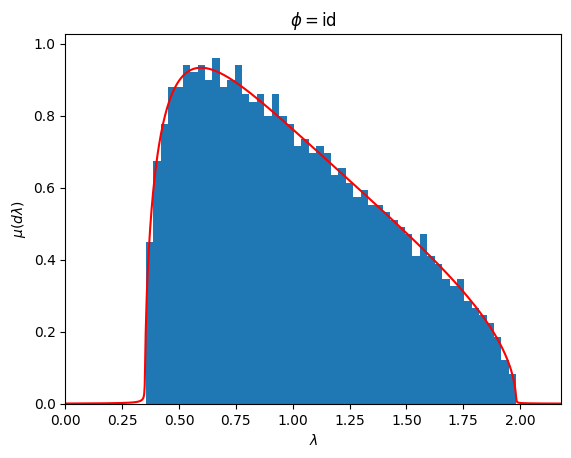

In [20]:
# Example: Marchenko-Pastur Law

phi = lambda x: x
phi1 = lambda x: 1
phi2 = lambda x: 0

alpha = 6
d = 20
n = int(alpha * d)

N = 1500

xmin, xmax = plotEmpirical(alpha, phi, phi1, phi2, N, 50)

def F(z):
    return 1 / (1 + z / alpha)

plotDensity(alpha, F, r'$\phi=\operatorname{id}$', 0, xmax*1.1)

Next, we are going to consider the Rectified Linear Unit (ReLU) defined as $\phi(x)=x\mathbf{1}_{[0,\infty)}(x)$. In this situation, we have derived that
$$F(z)=\frac{1}{2+\frac{2z}{\alpha}}.$$
We can proceed analogously as previously to find alignment with empirical data and the prediction made by Theorem 3.1.12:

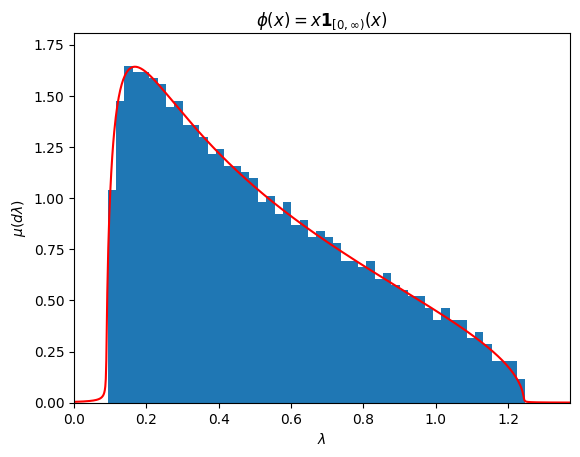

In [21]:
# Example: ReLU-Activation

phi = lambda x: max(0,x)
phi1 = lambda x: 0 if x<0 else 1
phi2 = lambda x: 0

alpha = 6
d = 20
n = int(alpha * d)

N = 1500

xmin, xmax = plotEmpirical(alpha, phi, phi1, phi2, N, 50)

def F(z):
    return 1 / (2 + 2*z / alpha)

plotDensity(alpha, F, r'$\phi(x)=x\mathbf{1}_{[0,\infty)}(x)$', 0, xmax*1.1)

Note that we have used the same model parameters $d$ and $\alpha$ as in Marchenko-Pastur. It matches our expectation that the ReLU-activation shifts the spectrum to the left and concentrates eigenvalues near $0$, since $\phi(x)=x\mathbf{1}_{[0,\infty)}$ causes entries of the Hessian $\mathcal{H}$ to vanish.

Let us consider a more interesting example, where the function $F(z)$ can only be approximated with the sequence $F_n(z)$. For this purpose, we consider the quadratic activation function $\phi(x)=x^2$. Since $\phi'(x)=2x$ and $\phi''(x)=2$, we have that the $\tau_\ell$ are non-trivially distributed which indeed makes
$$\frac{1}{n}\sum_{\ell=1}^n\frac{\tau_\ell}{1+\frac{\tau_\ell}{\alpha}z}\simeq\int_\Omega\frac{\tau(\omega)}{1+\frac{\tau(\omega)}{\alpha}z}\,P_\tau(d\omega)$$
challenging to explicitly compute as $n,d\to\infty$.

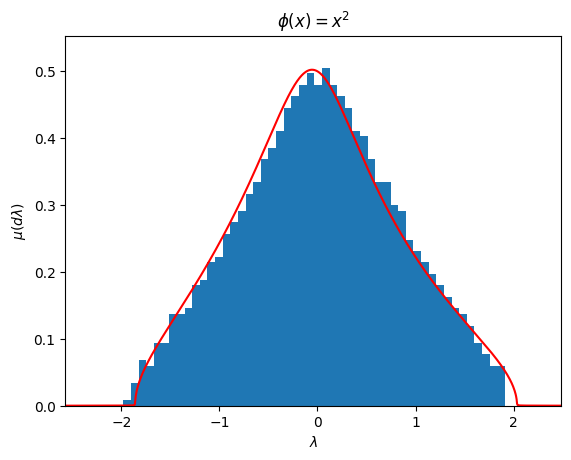

In [23]:
# Example: Quadratic Activation

phi = lambda x: x**2
phi1 = lambda x: 2*x
phi2 = lambda x: 2

alpha = 6
d = 20
n = int(alpha * d)

N = 1500

xmin, xmax = plotEmpirical(alpha, phi, phi1, phi2, N, 50)

# Limiting Spectral Distribution
K = 400
N = int(alpha * K)
X = np.random.normal(size=(K,N))
y = np.random.normal(size=(N,1))
w = np.random.normal(0, 1/K, size=(K,1))

def F(z):
    return approximateF(alpha, phi, phi1, phi2, X, w, y, K, z)

plotDensity(alpha, F, r'$\phi(x)=x^2}$', xmin*1.3, xmax*1.3)

Similarly, as done before, we present the results for the exponential activation $\phi(x)=e^x$. Observe that the spectrum encompasses both negative and positive eigenvalues.

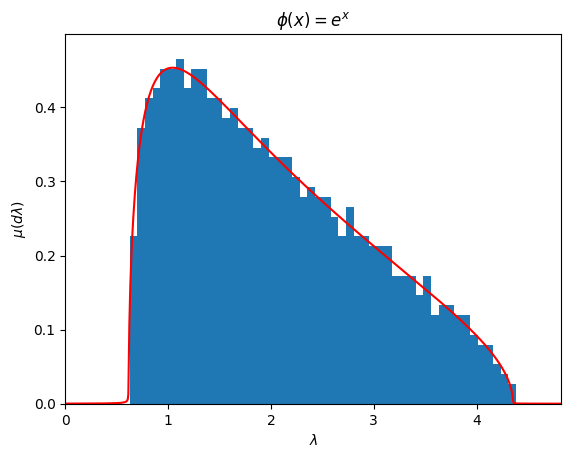

In [24]:
# Example: Exponential Activation

phi = lambda x: np.exp(x)
phi1 = lambda x: np.exp(x)
phi2 = lambda x: np.exp(x)

alpha = 6
d = 20
n = int(alpha * d)

N = 1000 # number of Hessian samples

xmin, xmax = plotEmpirical(alpha, phi, phi1, phi2, N, 50)

# Limiting Spectral Distribution
K = 400
N = int(alpha * K)
X = np.random.normal(size=(K,N))
y = np.random.normal(size=(N,1))
w = np.random.normal(0, 1/K, size=(K,1))

def F(z):
    return approximateF(alpha, phi, phi1, phi2, X, w, y, K, z)

plotDensity(alpha, F, r'$\phi(x)=e^x}$', 0, xmax*1.1)

Finally, we provide the data for the sigmoid activation
$$\phi(x)=\frac{1}{1+e^{-x}}.$$

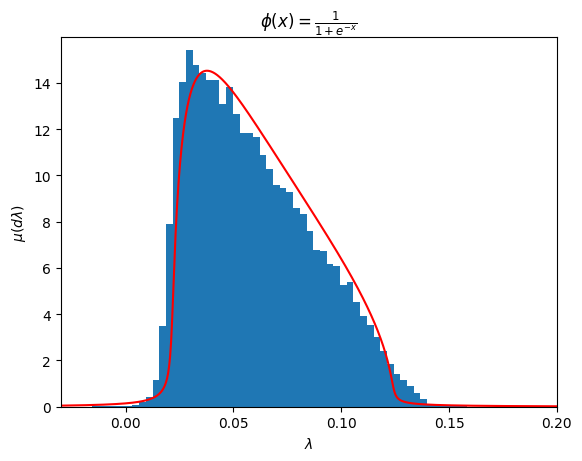

In [28]:
# Example: Sigmoid Activation

phi = lambda x: 1 / (1 + np.exp(-x))
phi1 = lambda x: np.exp(-x) / (np.exp(-x)+1)**2
phi2 = lambda x: 2*np.exp(-2*x) / (np.exp(-x)+1)**3 - np.exp(-x) / (np.exp(-x)+1)**2

alpha = 6
d = 20
n = int(alpha * d)

N = 1000 # using Monte-Carlo simulation, i.e. N = number of dxd Hessian samples

plotEmpiricalMC(N, alpha, phi, phi1, phi2, d)

# Limiting Spectral Distribution
K = 200
N = int(alpha * K)
X = np.random.normal(size=(K,N))
y = np.random.normal(size=(N,1))
w = np.random.normal(0, 1/K, size=(K,1))

def F(z):
    return approximateF(alpha, phi, phi1, phi2, X, w, y, K, z)

plotDensity(alpha, F, r'$\phi(x)=\frac{1}{1+e^{-x}}}$', -0.03, 0.2)

The prediction of Theorem 3.1.12 also includes a small amount of negative eigenvalues in the case of the sigmoid function.

## The Condition Number

We conclude with the comparison of the condition number of the previously discussed models. The condition number is defined to be
$$\kappa(\alpha):=\left|\frac{\lambda_+(\alpha)}{\lambda_-(\alpha)}\right|,$$
where $\lambda_\pm(\alpha)$ characterize the support of the continuous part of the limiting spectral distribution $\mu$, i.e. $\operatorname{supp}(\mu)=[\lambda_-(\alpha),\lambda_+(\alpha)]$.

\
\
In the case where $F(z)$ is simple enough to solve explicitly, the eigenvalues $\lambda_\pm(\alpha)$ also become easy to derive. For example, $\lambda_\pm(\alpha)=(1-\sqrt{\alpha^{-1}})^2$ if $\phi=\operatorname{id}$, and $\lambda_\pm(\alpha)=(\sqrt{2^{-1}}\pm \sqrt{\alpha^{-1}})^2$ if $\phi=\operatorname{ReLU}$. On the other hand, if $F(z)$ can only be approximated numerically, we would have to do the same for $\lambda_\pm(\alpha)$. We will use an approximation with random data for each iteration in $\alpha$. This is indeed a reasonable approach due to the previously observed alignment between the blue data and the red approximation.

In [1]:
# statistical approximation of kappa
def statApproxKappa(N, alphas, phi, phi1, phi2, d):

    kappas = []

    for alpha in alphas:
        ee = np.linalg.eigvalsh(sampleHessians(N, alpha, phi, phi1, phi2, d))
        lmin, lmax = np.mean(ee[:, 0]), np.mean(ee[:,-1])
        kappas.append(np.abs(lmax / lmin))

    return kappas

# approximation of kappa using theorem (use "exactF = -1" if F needs to be approximated)
def thmApproxKappa(N, alphas, phi, phi1, phi2, d, exactF, threshold):

    def findSupport(f, x):
        ind = np.where(f > threshold)[0] # the threshold seems a great impact on the quality of the approximation (since it determines the support)!
        a = x[np.min(ind)]
        b = x[np.max(ind)]
        return a, b

    kappas = []

    for alpha in alphas:

        def F(z):
            if exactF == -1: # WARNING: this case will take a long time to compute!
                n = int(alpha * d)
                X = np.random.normal(size=(d,n))
                y = np.random.normal(size=(n,1))
                w = np.random.normal(0, 1/d, size=(d,1))
                return approximateF(alpha, phi, phi1, phi2, X, w, y, d, z)
            else:
                return exactF(z, alpha)

        lambdas = np.linspace(-10, 10, num=1000)
        epsilons = np.logspace(4, -3, num=1000)
        m_values = 1

        for eps in epsilons:
            m_values = 1 / (F(m_values) - (lambdas + eps*1j)) # fixed point equation

        mu = np.imag(m_values) / np.pi # Stieltjes inversion

        lmin, lmax = findSupport(mu, lambdas)
        if lmin > 0.01:
            kappas.append(np.abs(lmax / lmin))
        else:
            kappas.append(np.inf)
    
    return kappas

We compare the our approximation to the exact formula. The approximation improves in quality by increasing both of the statistical parameters in (N,d). By increasing d, one increases the number of eigenvalues, meaning that we have more data for the approximation. The parameter N exploits the law of large numbers to smoothen the result by taking the average pointwise in alpha. We also implemented a version of finding $\kappa(\alpha)$ using Theorem 3.1.12. However, it is impractical to use when $F$ needs to be approximated, due to its immense computational complexity. On the other hand, if an exact formula for $F(z)$ is at our disposal, like in the two examples below, then it is indeed useful.

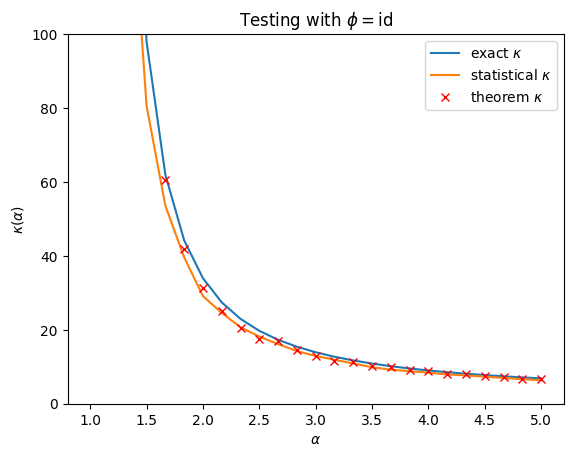

In [18]:
## Linear Activation

d = 100
N = 25

amin = 1
amax = 5

alphas = np.linspace(amin, amax, 25)

# exact kappa
with np.errstate(divide='ignore', invalid='ignore'):
    kappas = np.abs( (1 + np.sqrt(1 / alphas))**2 / (1 - np.sqrt(1 / alphas))**2 )


# approximated kappa
threshold = 0.05

phi = lambda x: x
phi1 = lambda x: 1
phi2 = lambda x: 0

plt.plot(alphas, kappas)
plt.plot(alphas, statApproxKappa(N, alphas, phi, phi1, phi2, d))
plt.plot(alphas, thmApproxKappa(N, alphas, phi, phi1, phi2, d, lambda z, alpha: 1 / (1 + z / alpha), threshold), 'x', color='red')
plt.ylim(0,100)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\kappa(\alpha)$')
plt.title('Testing with $\phi = \operatorname{id}$')
plt.legend(['exact $\kappa$', 'statistical $\kappa$', 'theorem $\kappa$'])

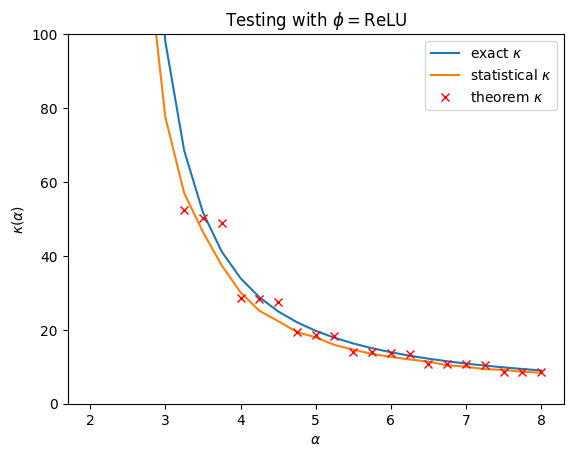

In [25]:
## ReLU-Activation

d = 100
N = 25

amin = 2
amax = 8

alphas = np.linspace(amin, amax, 25)

# exact kappa
with np.errstate(divide='ignore', invalid='ignore'):
    kappas = np.abs( (np.sqrt(1/2) + np.sqrt(1 / alphas))**2 / (np.sqrt(1/2) - np.sqrt(1 / alphas))**2 )


# approximated kappa
threshold = 0.05

phi = lambda x: max(0,x)
phi1 = lambda x: 0 if x<0 else 1
phi2 = lambda x: 0


plt.plot(alphas, kappas)
plt.plot(alphas, statApproxKappa(N, alphas, phi, phi1, phi2, d))
plt.plot(alphas, thmApproxKappa(N, alphas, phi, phi1, phi2, d, lambda z, alpha: 1 / (2 + 2*z / alpha), threshold), 'x', color='red')
plt.ylim(0,100)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\kappa(\alpha)$')
plt.title('Testing with $\phi = \operatorname{ReLU}$')
plt.legend(['exact $\kappa$', 'statistical $\kappa$', 'theorem $\kappa$'])

We will now use the statistical approximation of $\kappa(\alpha)$ to plot the condition, for comparison, of each model that was discussed before.

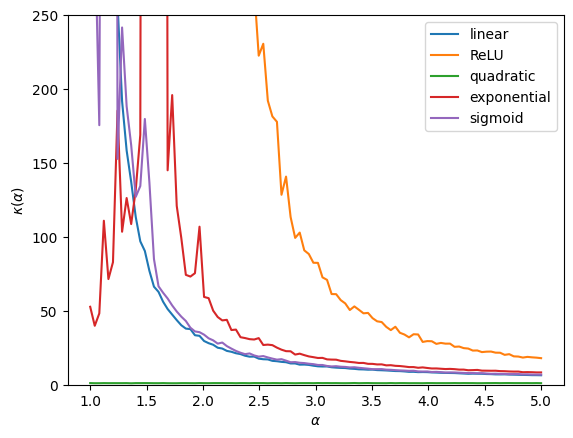

In [240]:
d = 100
N = 25

amin = 1
amax = 5

alphas = np.linspace(amin, amax, 100)


## Linear Activation

phi = lambda x: x
phi1 = lambda x: 1
phi2 = lambda x: 0


plt.plot(alphas, statApproxKappa(N, alphas, phi, phi1, phi2, d))


## ReLU Activation

phi = lambda x: max(0,x)
phi1 = lambda x: 0 if x<0 else 1
phi2 = lambda x: 0


plt.plot(alphas, statApproxKappa(N, alphas, phi, phi1, phi2, d))


## Quadratic Activation

phi = lambda x: x**2
phi1 = lambda x: 2*x
phi2 = lambda x: 2

plt.plot(alphas, statApproxKappa(N, alphas, phi, phi1, phi2, d))


## Exponential Activation

phi = lambda x: np.exp(x)
phi1 = lambda x: np.exp(x)
phi2 = lambda x: np.exp(x)

plt.plot(alphas, statApproxKappa(N, alphas, phi, phi1, phi2, d))


## Sigmoid Activation

phi = lambda x: 1 / (1 + np.exp(-x))
phi1 = lambda x: np.exp(-x) / (np.exp(-x)+1)**2
phi2 = lambda x: 2*np.exp(-2*x) / (np.exp(-x)+1)**3 - np.exp(-x) / (np.exp(-x)+1)**2

plt.plot(alphas, statApproxKappa(N, alphas, phi, phi1, phi2, d))

plt.ylim(0,250)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\kappa(\alpha)$')
plt.legend(['linear', 'ReLU', 'quadratic', 'exponential', 'sigmoid'])




Observe that the quadratic activation has a constant condition $\kappa(\alpha)$. Indeed, this makes sense after recalling the plot of the spectral density above: it seems that the support of the spectral density is symmetric around 0 for every $\alpha$, this particularly means that we have $\lambda_-(\alpha)=-\lambda_+(\alpha)$ and thus $\kappa(\alpha)=1$ for all $\alpha$. This also means that the Hessian is always indefinite, for all $\alpha$.

## Spectral Dynamics during Training

In this section we are interested in including the training of the nonlinear regression model and see what happens to the limiting spectral distribution. The only trainable parameter in our model is the weight vector $w\in\mathbb{R}^d$, which is initialized randomly in form of a Gaussian vector $w_0:\Omega\to\mathbb{R}^d$. Let $t>0$ be arbitrary. Then we can train the vector using a gradient flow method, i.e. we seek a solution $w_{(\cdot)}:(0,\infty)\to\mathbb{R}^d$ of the differential equation
$$\frac{\partial w_t}{\partial t} = w_t-M_t\nabla_w\mathcal{L}(w_t),\quad w_{t=0}=w_0,$$
where $\mathcal{L}$ is the least square loss-function and $M_t\in\mathbb{R}^{d\times d}$ a suitable matrix corresponding to the gradient method. Recall that the gradient elements of the loss are given by
$$\frac{\partial\mathcal{L}(w_t)}{\partial w_i}=\frac{1}{n}\sum_{k=1}^n(\phi(w_t^\top x_k)-y_k)\cdot\phi'(w_t^\top x_k)(x_k)_i,\quad i=1,\dots,d$$
Here are some examples for a choice of $M_t$, where $\eta_t$ denotes a non-increasing function:

* $M_t=\eta_t I_d$ (vanilla gradient descent with adaptable learning rates)
* $M_t=\mathcal{H}(w_t)^{-1}$ (second order gradient descent)
* $M_t=F^{-1}$ with fisher information matrix $F=\mathbb{E}\left[(\nabla_w\log \mathcal{L(w_t)})(\nabla_w\log \mathcal{L(w_t)})^\top \right]$ (natural gradient descent)

Of course, one can further improve the complexity of any gradient method by using stochastic variants rather than full-batch optimization.

From the fundamental theorem of calculus one easily obtains that the analytic solution of the differential equation above is given by
$$w_t=w_0-\int_0^t M_s\nabla_w\mathcal{L}(w_s)\,ds.$$

Numerically, we implement this using the iteration
$$w_{t+1}=w_t-M_t\nabla_w\mathcal{L}(w_t),\quad w_{t=0}=w_0.$$

Having a trained weight $w_t$ (trained up to time $t$) at our disposal, we can now easily describe the time-evolution of the Hessian. For $t\geq0$ we define the random process
$$\tau_\ell(t):=\phi'(w_t^\top x_\ell)^2+\phi''(w_t^\top x_\ell)(\phi(w_t^\top x_\ell)-y_\ell).$$
Then we have
$$\mathcal{H(w_t)}=\frac{1}{n}\sum_{\ell=1}^n\tau_\ell(t)\cdot x_\ell x_\ell^\top$$
The exact same proof of the first main result can be applied to achieve

\
\
**Theorem (Generalized Main Result I)** *Let $t\geq0$ be arbitrary. Denote $Q_{d,t}(z)$ to be the resolvent of $\mathcal{H}(w_t)$ and assume that there exists a Stieltjes transform $m_t$ (of some probability measure $\mu_t$) such that $m_{d,t}(z):=\frac{1}{d}\operatorname{Tr}Q_{d,t}(z)\stackrel{a.s.}{\to}m_t(z)$ for all $z\in\mathbb{C}_+$, $n/d\to\alpha\in(0,\infty)$ and that there exists a function $F_t:\mathbb{C}_+\to\mathbb{C}_+$ such that, point-wise,*
$$F_{n,t}(z):=\frac{1}{n}\sum_{\ell=1}^n \frac{\tau_\ell(t)}{1+\frac{\tau_\ell(t)}{\alpha}z}\stackrel{a.s.}{\to}F_t(z)$$
*as $n,d\to\infty$. Then the Stieltjes transform $m_t(z)$ satisfies the fixed point equation*
$$m_t(z)=\frac{1}{F_t(m_t(z))-z}$$
*for all $z\in\mathbb{C}_+$.*


The theorem provides a time-dependent fixed point equation for the Stieltjes transform at time $t\geq0$ and thus describes the dynamics of the limiting spectral distribution during training. We will now numerically study this result.

In [29]:
## Implementing Gradient Descent

# output of non-linear regression model
def model(X, w, phi):
    return phi(np.dot(X.T, w))

# computes the least square loss function
def lossFunction(X, y, w, phi):

    y_model = model(X, w, phi)
    n = X.shape[1]
    loss = 1/(2*n) * np.linalg.norm(y_model - y)

    return loss

# computes the gradient of the least square loss
def gradient(X, y, w, phi, phi1):

    grad = []

    for i in range(X.shape[0]):

        sum = 0

        for l in range(X.shape[1]):
            sum += (phi(np.dot(w.T, X[:,l])) - y[l]) * phi1(np.dot(w.T, X[:,l])) * X[i,l]

        grad.append(sum)

    return 1 / X.shape[1] * np.array(grad)

            
# returns weights and loss after single update
def singleUpdate(X, y, w, phi, phi1):

    learning_rate = 0.01
    grad = gradient(X, y, w, phi, phi1)

    w = w - learning_rate * grad # single gradient descent update

    return w, lossFunction(X, y, w, phi)

percentage of improvement (linear): 0.9352929946734663
percentage of improvement (ReLU): 0.9354661036344878
percentage of improvement (quadratic): 0.8943198881369839
percentage of improvement (exponential): 0.9257309888318107
percentage of improvement (sigmoid): 0.10080531186555919


Text(0.5, 1.0, 'using linear data')

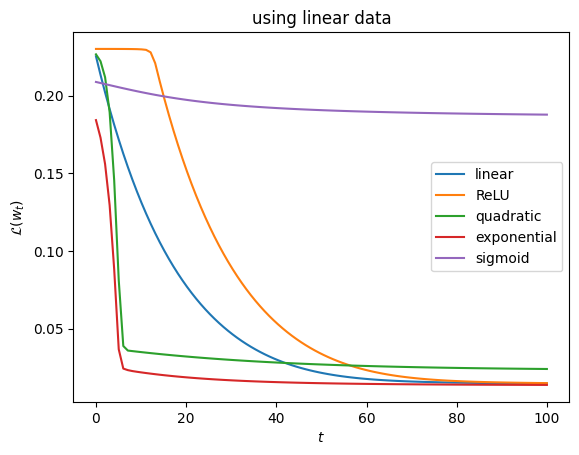

In [301]:
## Testing Learning of our Model

# data initialization

alpha = 6
d = 20
n = int(alpha * d)

data = "linear" # our model is only useful for linear data

if data == "gaussian":
    X = np.random.normal(size=(d,n))
    y = np.random.normal(size=(n,1))

elif data == "linear":
    X = np.random.rand(d,n)
    true_weights = np.random.rand(d,1)
    y = np.dot(X.T, true_weights)

# random weight initialization
w = np.random.normal(0, 1/d, size=(d,1))


# training the model & plot results

def plotLossDynamics(X, y, w, phi, phi1, model_name):
    
    t_end = 100

    times = np.linspace(0, t_end, num=t_end)
    #weights = []
    losses = []

    for t in times:

        w, loss = singleUpdate(X, y, w, phi, phi1)

        #weights.append(w)
        losses.append(loss)


    plt.plot(times, losses)
    plt.xlabel('$t$')
    plt.ylabel('$\mathcal{L}(w_t)$')
    print(f"percentage of improvement ({model_name}):", 1 - losses[-1]/losses[0])


## Model Comparison

phi_linear = lambda x: x
phi1_linear = lambda x: 1

phi_ReLU = lambda x: np.maximum(0,x)
phi1_ReLU = lambda x: 0 if x<0 else 1

phi_quadratic = lambda x: x**2
phi1_quadratic = lambda x: 2*x

phi_exponential = lambda x: np.exp(x)
phi1_exponential = lambda x: np.exp(x)

phi_sigmoid = lambda x: 1 / (1 + np.exp(-x))
phi1_sigmoid = lambda x: np.exp(-x) / (np.exp(-x)+1)**2

plotLossDynamics(X, y, w, phi_linear, phi1_linear, 'linear')
plotLossDynamics(X, y, w, phi_ReLU, phi1_ReLU, 'ReLU')
plotLossDynamics(X, y, w, phi_quadratic, phi1_quadratic, 'quadratic')
plotLossDynamics(X, y, w, phi_exponential, phi1_exponential, 'exponential')
plotLossDynamics(X, y, w, phi_sigmoid, phi1_sigmoid, 'sigmoid')

plt.legend(['linear', 'ReLU', 'quadratic', 'exponential', 'sigmoid'])
plt.title(f"using {data} data")

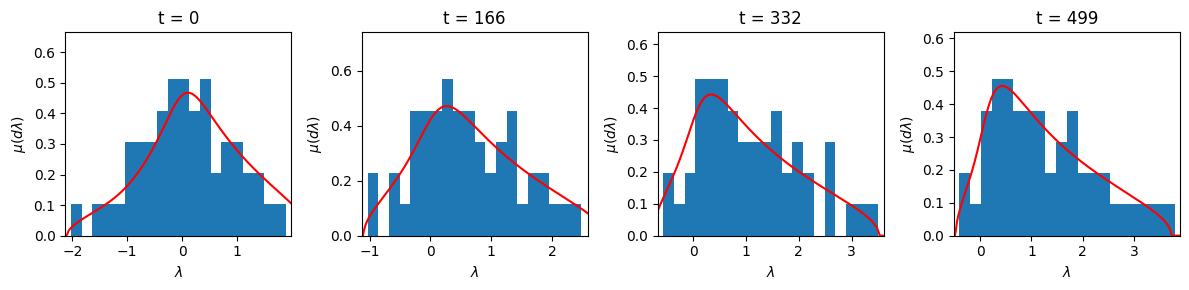

In [33]:
## Comparing Dynamics of Empirical Data with Theoretical Prediction

activation = "quadratic"

if activation == "linear":
    phi = lambda x: x
    phi1 = lambda x: 1
    phi2 = lambda x: 0

elif activation == "ReLU":
    phi = lambda x: np.maximum(0,x)
    phi1 = lambda x: 0 if x<0 else 1
    phi2 = lambda x: 0

elif activation == "quadratic":
    phi = lambda x: x**2
    phi1 = lambda x: 2*x
    phi2 = lambda x: 2

elif activation == "exponential":
    phi = lambda x: np.exp(x)
    phi1 = lambda x: np.exp(x)
    phi2 = lambda x: np.exp(x)

elif activation == "sigmoid":
    phi = lambda x: 1 / (1 + np.exp(-x))
    phi1 = lambda x: np.exp(-x) / (np.exp(-x)+1)**2
    phi2 = lambda x: 2*np.exp(-2*x) / (np.exp(-x)+1)**3 - np.exp(-x) / (np.exp(-x)+1)**2

# generate data
alpha = 6
d = 50
n = int(alpha * d)

X = np.random.normal(size=(d,n))
y = np.random.normal(size=(n,1))

w = np.random.normal(0, 1/d, size=(d,1)) # randomly initialized weights

# training weights
t_end = 500

times = np.linspace(0, t_end, num=t_end)
weights = []

for t in times:

    w, _ = singleUpdate(X, y, w, phi, phi1)

    weights.append(w)

def trainedSingleHessian(alpha, phi, phi1, phi2, X, y, d, w_trained):
    
    n = int(alpha * d)

    # generate diagonal matrix
    vec = []

    for l in range(n):
        tau = computeTau(alpha, phi, phi1, phi2, X, w_trained, y, l)
        vec = np.append(vec, tau)

    D = np.diag(vec)

    # return Hessian
    return np.dot(np.dot(X, D), X.T) / n


# plot empirical data and theoretical density
number_of_plots = 4
milestones = np.linspace(0, t_end - 1, number_of_plots, dtype=int)

fig, axs = plt.subplots(1, len(milestones), figsize=(12, 3))

for i, t in enumerate(milestones):

    ax = axs[i]

    # plot theoretical density
    def F(z):
        return approximateF(alpha, phi, phi1, phi2, X, weights[t], y, d, z)
    
    lambdas = np.linspace(-10, 10, num=1000)
    epsilons = np.logspace(4, -3, num=1000)
    m_values = 1

    for eps in epsilons:
        m_values = 1 / (F(m_values) - (lambdas + eps*1j)) # fixed point equation

    mu = np.imag(m_values) / np.pi # Stieltjes inversion

    ax.plot(lambdas, mu, color='red')

    # plot empirical data
    bins = 20
    ee, ev = np.linalg.eigh(trainedSingleHessian(alpha, phi, phi1, phi2, X, y, d, weights[t]))
    nn, bb, _ = ax.hist(ee.ravel(), bins=bins, density=True)

    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel(r'$\mu(d\lambda)$')
    ax.set_ylim(top=nn[1:].max() * 1.3)
    ax.set_xlim(bb.min() - 0.1, bb.max() + 0.1)
    ax.set_title('t = {}'.format(t))

plt.tight_layout()

In [ ]:
## Plotting Spectral Distributions during Training

# reconstruct limiting spectral density
def plotTrainedDensity(alpha, F, title, xmin, xmax):

    lambdas = np.linspace(xmin, xmax , num=1000)
    epsilons = np.logspace(4, -3, num=1000)
    m_values = 1

    for eps in epsilons:
        m_values = 1 / (F(m_values) - (lambdas + eps*1j)) # fixed point equation

    mu = np.imag(m_values) / np.pi # Stieltjes inversion

    def findSupport(f, x):
        ind = np.where(f > 0.01)[0]
        a = x[np.min(ind)]
        b = x[np.max(ind)]
        return a, b
    
    lmin, lmax = findSupport(mu, lambdas)

    plt.plot(lambdas, mu)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\mu(d\lambda)$')
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(top=mu.max() * 1.1)

    return max(mu), lmin, lmax

percentage of improvement (gaussian): 0.05239458260082508


(-1.2311311311311308, 3.313213213213214)

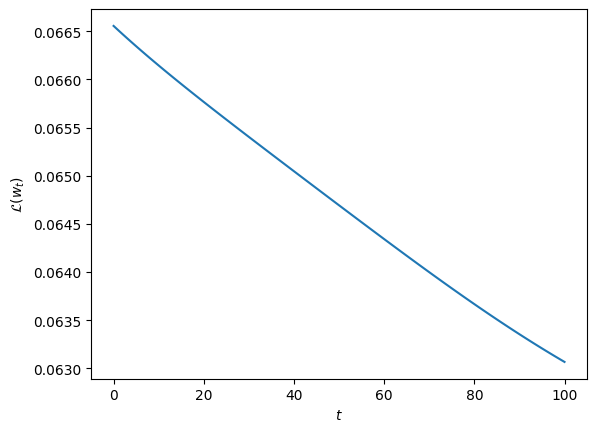

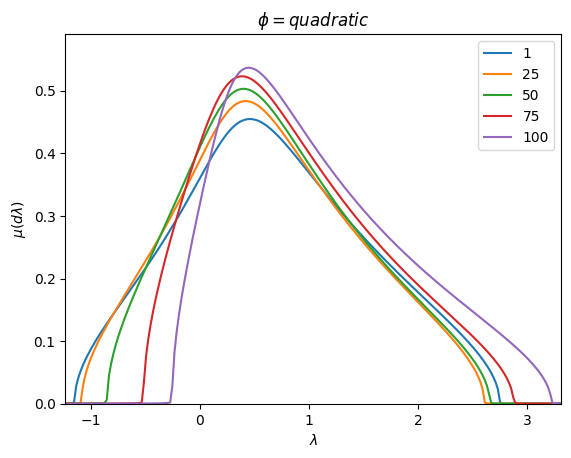

In [323]:
## Testing Different Models

activation = "quadratic"

if activation == "linear":
    phi = lambda x: x
    phi1 = lambda x: 1
    phi2 = lambda x: 0

elif activation == "ReLU":
    phi = lambda x: np.maximum(0,x)
    phi1 = lambda x: 0 if x<0 else 1
    phi2 = lambda x: 0

elif activation == "quadratic":
    phi = lambda x: x**2
    phi1 = lambda x: 2*x
    phi2 = lambda x: 2

elif activation == "exponential":
    phi = lambda x: np.exp(x)
    phi1 = lambda x: np.exp(x)
    phi2 = lambda x: np.exp(x)

elif activation == "sigmoid":
    phi = lambda x: 1 / (1 + np.exp(-x))
    phi1 = lambda x: np.exp(-x) / (np.exp(-x)+1)**2
    phi2 = lambda x: 2*np.exp(-2*x) / (np.exp(-x)+1)**3 - np.exp(-x) / (np.exp(-x)+1)**2


# Limiting Spectral Distribution
alpha = 6
K = 10
N = int(alpha * K)

data = "gaussian"

if data == "gaussian":
    X = np.random.normal(size=(K,N))
    y = np.random.normal(size=(N,1))

elif data == "linear":
    X = np.random.rand(K,N)
    true_weights = np.random.rand(K,1)
    y = np.dot(X.T, true_weights)

w = np.random.normal(0, 1/K, size=(K,1)) # randomly initialized weights

# training weights & plot loss dynamics
t_end = 100

times = np.linspace(0, t_end, num=t_end)
weights = []
losses = []

for t in times:

    w, loss = singleUpdate(X, y, w, phi, phi1)

    weights.append(w)
    losses.append(loss)

print(f"percentage of improvement ({data}):", 1 - losses[-1]/losses[0])

plt.figure(1)
plt.plot(times, losses)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(w_t)$')

# plot trained spectral densities
number_of_plots = 5
milestones = np.linspace(0, t_end - 1, number_of_plots, dtype=int)

ylimit = []
xlimit_min = []
xlimit_max = []

plt.figure(2)

for t in milestones:

    def F(z):
        return approximateF(alpha, phi, phi1, phi2, X, weights[t], y, K, z)
    
    max_mu, lmin, lmax = plotTrainedDensity(alpha, F, f'$\phi={activation}$', -10, 10)
    
    ylimit.append(max_mu)
    xlimit_min.append(lmin)
    xlimit_max.append(lmax)

plt.legend(milestones + 1)
plt.ylim(0,max(ylimit) * 1.1)
plt.xlim(min(xlimit_min) - 0.1, max(xlimit_max) + 0.1)